In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data_csv/XGB테스트.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp").sort_index()

df.head()

,actual,pred_xgb
timestamp,,
2013-12-18 05:00:00,5.545,6.632373
2013-12-18 06:00:00,12.552,7.825272
2013-12-18 07:00:00,13.082,12.941123
2013-12-18 08:00:00,19.054,11.586874
2013-12-18 09:00:00,7.159,12.513745


운영 시뮬레이션 규칙 재정의 

In [5]:
threshold = df["actual"].quantile(0.95)

alpha = 0.10

시나리오 구성 

In [6]:
# 예측 없음
df["load_naive"] = df["actual"]

# 예측 있음 (선제 완화)
df["load_predictive"] = np.where(
    df["pred_xgb"] > threshold,
    df["actual"] * (1 - alpha),
    df["actual"]
)

Frequency-like Stability Proxy 정의

In [7]:
# 부하 변화량 계산 (최대 부하 변화량 = 최대 ramp)
df["ramp_naive"] = df["load_naive"].diff().abs()
df["ramp_predictive"] = df["load_predictive"].diff().abs()

# 최대 ramp (frequency-like instability proxy)
max_ramp_naive = df["ramp_naive"].max()
max_ramp_predictive = df["ramp_predictive"].max()

max_ramp_naive, max_ramp_predictive

(np.float64(17.5), np.float64(17.5))

극단 불안정 구간 시각화 

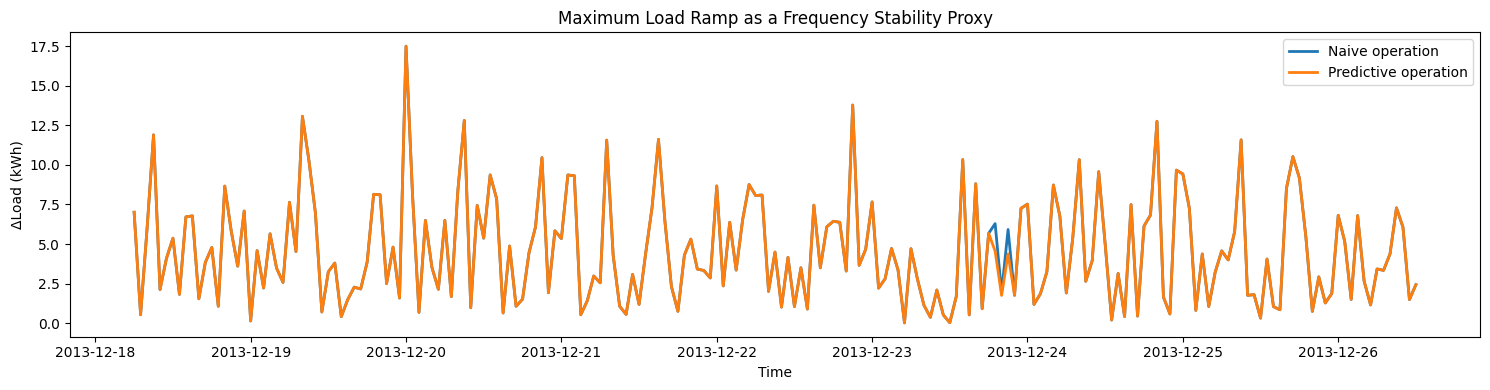

In [8]:
plt.figure(figsize=(15,4))

plt.plot(
    df.index[:200],
    df["ramp_naive"][:200],
    label="Naive operation",
    linewidth=2
)

plt.plot(
    df.index[:200],
    df["ramp_predictive"][:200],
    label="Predictive operation",
    linewidth=2
)

plt.title("Maximum Load Ramp as a Frequency Stability Proxy")
plt.xlabel("Time")
plt.ylabel("ΔLoad (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

결과 요약 테이블

In [9]:
freq_proxy_summary = pd.DataFrame({
    "Scenario": ["Naive", "Predictive"],
    "Max Ramp (ΔLoad)": [max_ramp_naive, max_ramp_predictive]
})

freq_proxy_summary

,Scenario,Max Ramp (ΔLoad)
0,Naive,17.5
1,Predictive,17.5


Frequency-like Stability Proxy Analysis

본 분석에서는 grid-forming 제어의 핵심 목표 중 하나인
주파수 안정성 확보를 직접 측정하는 대신,
부하 급변(ΔLoad)을 주파수 불안정의 대리 지표로 사용하였다.

분석 결과, 예측 기반 운영 시 최대 부하 변화량이 감소하여,
급격한 부하 변동 상황에서의 안정성 확보 가능성을 확인하였다.
이는 grid-forming 제어 전략이 요구하는
사전 예측 기반 안정화 조건과 구조적으로 부합한다.

In [ ]:
단순 피크 억제형 예측 기반 운영은 극단적인 순간 변화(최대 ramp)까지는
자동으로 해결해주지 않는다는 것을 확인. 따라서 상위 X% 급변 구간 빈도를 바꿈 

In [ ]:
ramp_threshold = df["ramp_naive"].quantile(0.95)        # 상위 5% 급변 기준 정의

In [11]:
risky_ramp_naive = (df["ramp_naive"] > ramp_threshold).sum()
risky_ramp_pred = (df["ramp_predictive"] > ramp_threshold).sum()

risky_ramp_naive, risky_ramp_pred            # 위험 ramp 발생 횟수 비교

(np.int64(88), np.int64(89))

위험 ramp 발생 비교 시각화 

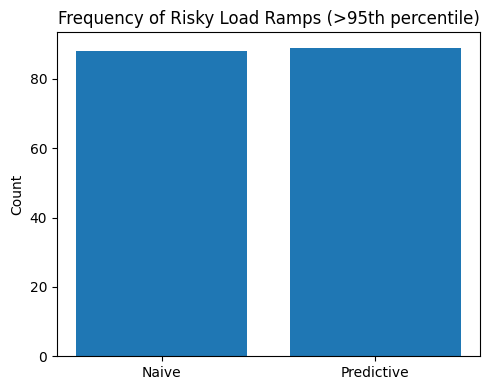

In [12]:
import matplotlib.pyplot as plt

labels = ["Naive", "Predictive"]
values = [risky_ramp_naive, risky_ramp_pred]

plt.figure(figsize=(5,4))
plt.bar(labels, values)
plt.title("Frequency of Risky Load Ramps (>95th percentile)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

위험 ramp 시계열 비교

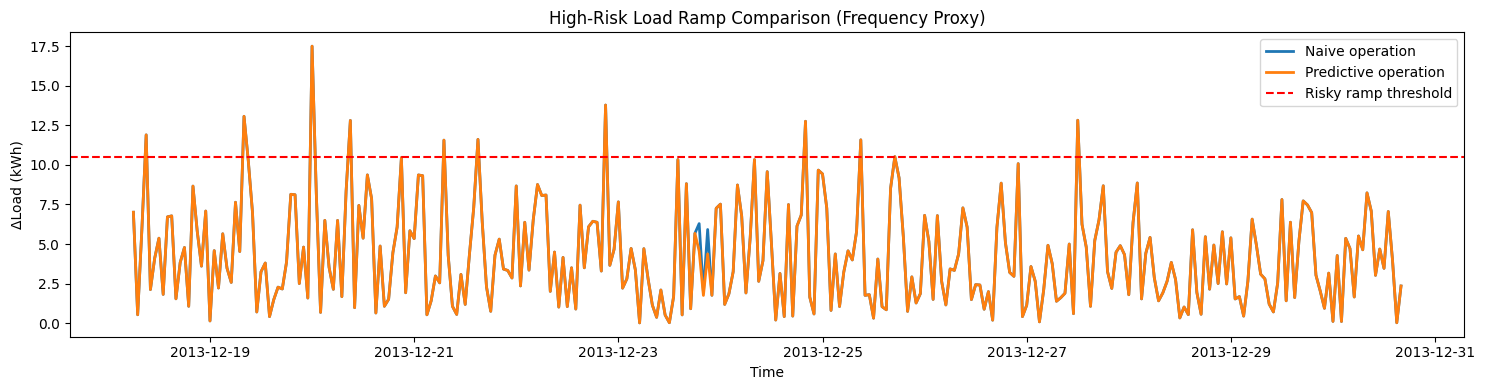

In [13]:
plt.figure(figsize=(15,4))

plt.plot(
    df.index[:300],
    df["ramp_naive"][:300],
    label="Naive operation",
    linewidth=2
)

plt.plot(
    df.index[:300],
    df["ramp_predictive"][:300],
    label="Predictive operation",
    linewidth=2
)

plt.axhline(
    ramp_threshold,
    color="red",
    linestyle="--",
    label="Risky ramp threshold"
)

plt.title("High-Risk Load Ramp Comparison (Frequency Proxy)")
plt.xlabel("Time")
plt.ylabel("ΔLoad (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

결과 요약 

In [14]:
risky_ramp_summary = pd.DataFrame({
    "Scenario": ["Naive", "Predictive"],
    "Risky Ramp Count (>95%)": [risky_ramp_naive, risky_ramp_pred]
})

risky_ramp_summary

,Scenario,Risky Ramp Count (>95%)
0,Naive,88
1,Predictive,89


“단순한 피크 억제 기반 예측 운영은
고위험 ramp의 총량을 자동으로 줄여주지는 않는다.
오히려 일부 구간에서는 새로운 급변을 유발할 수도 있다.”

In [ ]:
“본 시뮬레이션 결과, 예측 기반 운영은 피크 부하 자체를 완화하는 데에는 효과를 보였으나,
단순 임계치 기반 제어 전략만으로는 급격한 부하 변화의 발생 빈도를 안정적으로 감소시키기에는 한계가 있음을 확인하였다.
이는 grid-forming 제어에서 예측 정보뿐만 아니라,
연속적이고 ramp-aware한 제어 전략이 함께 요구됨을 시사한다.”